# Overview


This notebook solves a toy inverse problem with a physics-informed neural network (PINN). It defines the synthetic setup, trains the model, and visualizes the learned solution.

## Discrete Inverse Setup And Loss


We solve a 1D Poisson problem on $x \in [0,1]$ with a PINN approximation $u_\theta(x)$:

- PDE: $u_{xx} + \pi^2 \sin(\pi x) = 0$ (i.e., $u_{xx} = -\pi^2 \sin(\pi x)$).
- Collocation points: $x_{\text{domain}} = \mathrm{linspace}(0,1,100)$.
- Boundary points: $x_{\text{bc}} = \{0,1\}$ with $u(0)=u(1)=0$.

The loss is the sum of a PDE residual term and a boundary term:

- Residual: $r(x) = u_{xx}(x) - f(x)$ with $f(x) = -\pi^2 \sin(\pi x)$.
- $\mathcal{L}_{\text{pde}} = \frac{1}{N}\sum r(x_i)^2$ over collocation points.
- $\mathcal{L}_{\text{bc}} = \mathrm{MSE}(u_\theta(x_{\text{bc}}), u_{\text{bc}})$.
- Total: $\mathcal{L} = \mathcal{L}_{\text{pde}} + \mathcal{L}_{\text{bc}}$.

## PINN Inverse Problem: toy case

Epoch 0, Loss: 4.91255e+01
Epoch 500, Loss: 6.62939e-04
Epoch 1000, Loss: 4.98268e-04
Epoch 1500, Loss: 3.59567e-04
Epoch 2000, Loss: 2.37181e-04
Epoch 2500, Loss: 1.42965e-04
Epoch 3000, Loss: 8.59626e-05
Epoch 3500, Loss: 5.91563e-05
Epoch 4000, Loss: 4.63672e-05
Epoch 4500, Loss: 3.81976e-05


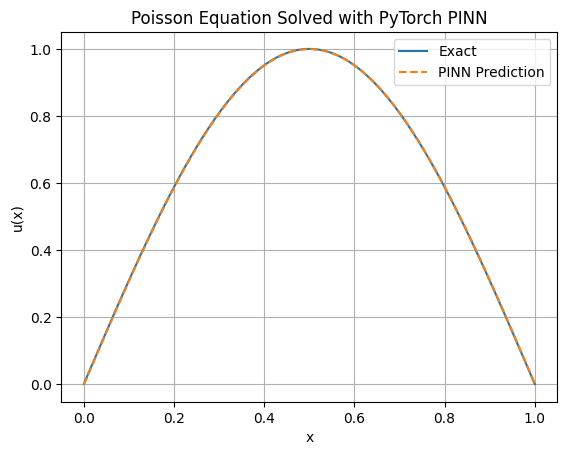

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        return self.net(x)

# Define the PDE residual: u_xx + pi^2 * sin(pi x) = 0
def pde_residual(model, x):
    x.requires_grad_(True)
    u = model(x)
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = - (np.pi**2) * torch.sin(np.pi * x)
    return u_xx - f

# Training data
n_domain = 100
n_bc = 2
x_domain = torch.linspace(0, 1, n_domain).reshape(-1, 1).to(device)
x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(device)
u_bc = torch.zeros((n_bc, 1)).to(device)

# Model setup
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
for epoch in range(5000):
    optimizer.zero_grad()

    # PDE loss
    res = pde_residual(model, x_domain)
    loss_pde = torch.mean(res**2)

    # Boundary loss
    u_pred_bc = model(x_bc)
    loss_bc = loss_fn(u_pred_bc, u_bc)

    loss = loss_pde + loss_bc
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

# Evaluation
x_test = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
u_pred = model(x_test).detach().cpu().numpy()
u_true = np.sin(np.pi * x_test.cpu().numpy())

# Plotting
plt.plot(x_test.cpu(), u_true, label="Exact")
plt.plot(x_test.cpu(), u_pred, "--", label="PINN Prediction")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.title("Poisson Equation Solved with PyTorch PINN")
plt.grid(True)
plt.show()
